In [96]:
from sklearn import datasets
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

In [97]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [98]:
df = datasets.load_breast_cancer()
df.data.shape

(569, 30)

In [99]:
df['data'].shape

(569, 30)

In [100]:
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)



In [101]:
data = np.concatenate([df['data'], df['target'].reshape(-1, 1)], axis=1)

In [102]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df[:,-1]).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df[:,-1]).reshape(-1, 1)
test_labels = np.array(test_df[:,-1]).reshape(-1, 1)

train_features = np.array(train_df[:,:-1])
val_features = np.array(val_df[:,:-1])
test_features = np.array(test_df[:,:-1])

In [103]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# train_features = np.clip(train_features, -5, 5)
# val_features = np.clip(val_features, -5, 5)
# test_features = np.clip(test_features, -5, 5)

In [104]:
# output_bias = keras.initializers.Constant(initial_bias)
N_value = train_features.shape[1]
inputs = keras.Input(shape=(N_value,))

# Reshape to (batch, N, 1) to treat each feature as a token.
x = keras.layers.Reshape((N_value, 1))(inputs)

# Self-attention block:
# Using one head with key_dim=1 so that the attention scores have shape (batch, 1, N, N)
attn_layer = keras.layers.MultiHeadAttention(num_heads=4,key_dim=15)
# We set return_attention_scores=True to obtain the attention matrix.
output_tensor, attn_scores = attn_layer(x, x, return_attention_scores=True, )
# Remove the head dimension so attn_scores becomes (batch, N, N)
# attn_scores = keras.layers.Lambda(lambda t: tf.squeeze(t, axis=1))(attn_scores)

# Apply layer normalization to the attention matrix.
x = keras.layers.LayerNormalization()(output_tensor)

# # Option 1: Global pooling over the token dimension to reduce (N, N) to a vector of length N.
# x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Flatten()(x)

# # MLP block:
# Dense layers with sizes: 4*N, 2*N, N and output layer with 2 units.
x = keras.layers.Dense(4 * N_value, activation='relu')(x)
x = keras.layers.Dense(2 * N_value, activation='relu')(x)
x = keras.layers.Dense(N_value, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
)

In [105]:
EPOCHS = 200
BATCH_SIZE = 32

history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    verbose=1,
    callbacks=[early_stopping()])

Epoch 1/200


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - Brier score: 0.2498 - accuracy: 0.5765 - auc: 0.5000 - cross entropy: 0.6928 - fn: 18.0000 - fp: 70.3077 - loss: 0.6928 - prc: 0.6072 - precision: 0.5739 - recall: 0.7659 - tn: 14.0000 - tp: 116.1538 - val_Brier score: 0.2495 - val_accuracy: 0.5934 - val_auc: 0.5000 - val_cross entropy: 0.6922 - val_fn: 0.0000e+00 - val_fp: 37.0000 - val_loss: 0.6922 - val_prc: 0.5934 - val_precision: 0.5934 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 54.0000
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - Brier score: 0.2492 - accuracy: 0.6222 - auc: 0.5109 - cross entropy: 0.6916 - fn: 0.0000e+00 - fp: 82.1538 - loss: 0.6916 - prc: 0.6281 - precision: 0.6222 - recall: 1.0000 - tn: 0.0000e+00 - tp: 136.3077 - val_Brier score: 0.2491 - val_accuracy: 0.5934 - val_auc: 0.5000 - val_cross entropy: 0.6913 - val_fn: 0.0000e+00 - val_fp: 37.0000 - val_loss: 0.6913 - val_prc: 0.5934 - val_precision: 0.5934 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val

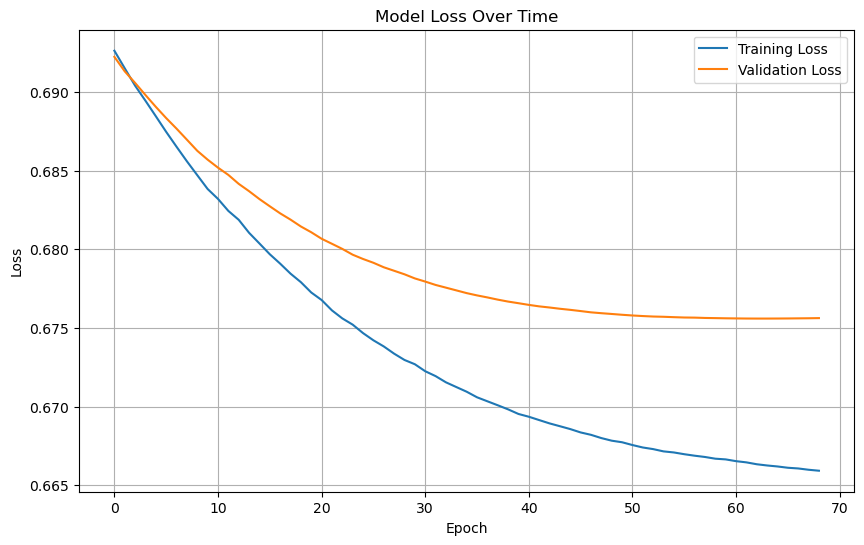

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [107]:
mean_attn_array = []
attn = model.layers[2]

for x in train_features:
    _, attention_scores = attn(x.reshape(1,-1,1), x.reshape(1,-1,1), return_attention_scores=True) # take one sample
    mean_attn_array.append(attention_scores[0, 0, :, :])

mean_attn_array = np.array(mean_attn_array)
mean_attn = mean_attn_array.mean(axis=0)


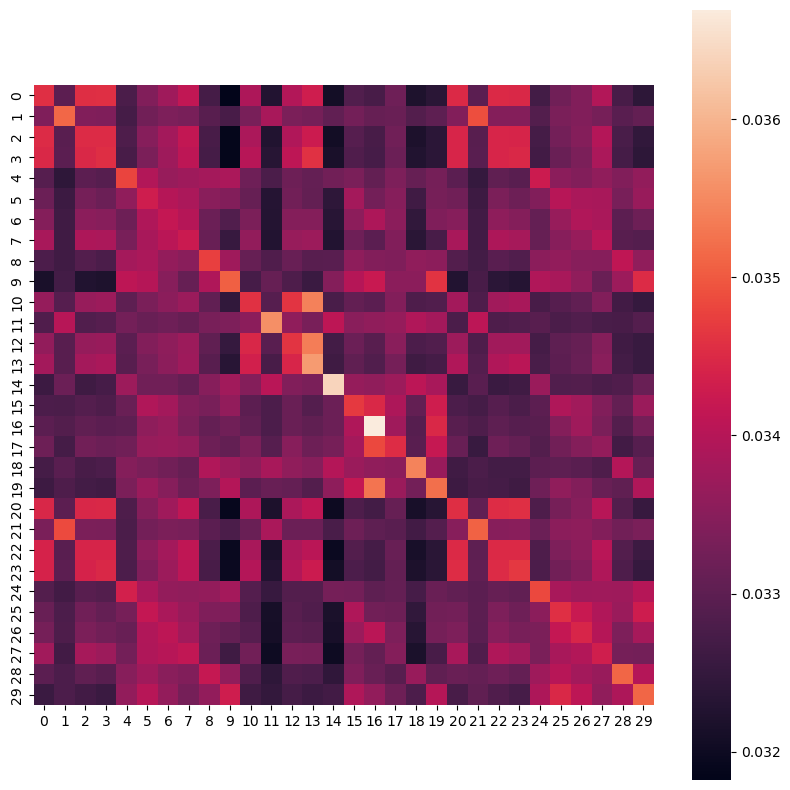

In [108]:
plt.figure(figsize=(10,10))
sb.heatmap(mean_attn, annot=False, cbar=True, square=True, fmt='.2f')
plt.show()


In [61]:
mean_attn.sum(axis=0)

array([1.0048795 , 0.9857804 , 1.0068898 , 1.0069373 , 0.99663454,
       1.0154456 , 1.0184869 , 1.0173974 , 0.99481124, 0.98590344,
       1.0030639 , 0.9760068 , 1.0040241 , 1.000955  , 0.9768576 ,
       1.0032284 , 0.993861  , 1.0049958 , 0.9784756 , 0.9900349 ,
       1.0075777 , 0.98772943, 1.0097495 , 1.0086454 , 0.9942519 ,
       1.0104882 , 1.0122834 , 1.0146084 , 0.99265563, 0.9973408 ],
      dtype=float32)

In [62]:
cols = df['feature_names']

# sort cols by max attention
att_sum = mean_attn.sum(axis=0)
cols[att_sum.argsort()[::-1]]


array(['mean concavity', 'mean concave points', 'mean compactness',
       'worst concave points', 'worst concavity', 'worst compactness',
       'worst perimeter', 'worst area', 'worst radius', 'mean area',
       'mean perimeter', 'concave points error', 'mean radius',
       'perimeter error', 'compactness error', 'radius error',
       'area error', 'worst fractal dimension', 'mean smoothness',
       'mean symmetry', 'worst smoothness', 'concavity error',
       'worst symmetry', 'fractal dimension error', 'worst texture',
       'mean fractal dimension', 'mean texture', 'symmetry error',
       'smoothness error', 'texture error'], dtype='<U23')


Lasso Regression Feature Importance:
                    feature  importance
20             worst radius    0.141050
27     worst concave points    0.101255
1              mean texture    0.068755
26          worst concavity    0.058851
24         worst smoothness    0.053894
10             radius error    0.045886
28           worst symmetry    0.032952
9    mean fractal dimension    0.029699
7       mean concave points    0.020512
0               mean radius    0.012787
15        compactness error    0.004760
21            worst texture    0.000598
5          mean compactness    0.000000
2            mean perimeter    0.000000
13               area error    0.000000
12          perimeter error    0.000000
11            texture error    0.000000
8             mean symmetry    0.000000
6            mean concavity    0.000000
3                 mean area    0.000000
4           mean smoothness    0.000000
14         smoothness error    0.000000
18           symmetry error    0.000000
19

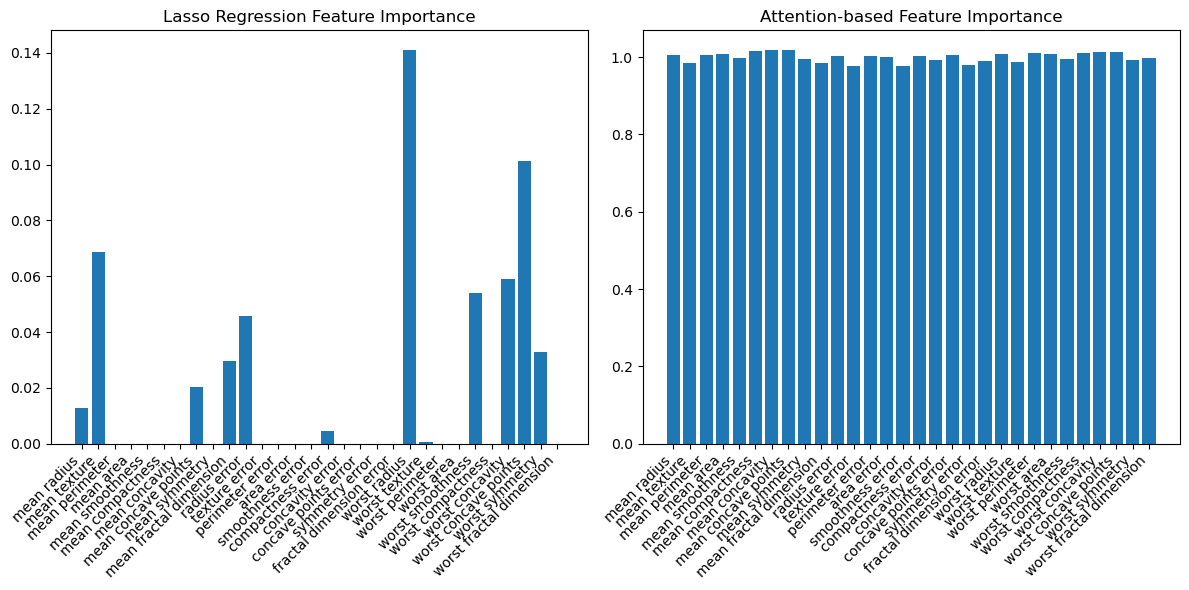

In [63]:

# Lasso Regression Analysis
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_features)

# Fit Lasso regression
lasso = Lasso(alpha=0.01)  # Small alpha for less aggressive regularization
lasso.fit(X_scaled, train_labels.ravel())

# Get feature importance (absolute coefficients)
lasso_importance = np.abs(lasso.coef_)

# Sort features by importance
lasso_feature_importance = pd.DataFrame({
    'feature': cols,
    'importance': lasso_importance
}).sort_values('importance', ascending=False)

print("\nLasso Regression Feature Importance:")
print(lasso_feature_importance)

# Compare with attention-based importance
att_sum = mean_attn.sum(axis=0)
attention_feature_importance = pd.DataFrame({
    'feature': cols,
    'importance': att_sum
}).sort_values('importance', ascending=False)

print("\nAttention-based Feature Importance:")
print(attention_feature_importance)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(lasso_importance)), lasso_importance)
plt.title('Lasso Regression Feature Importance')
plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.bar(range(len(att_sum)), att_sum)
plt.title('Attention-based Feature Importance')
plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
plt.tight_layout()
plt.show()





